In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('btc_1h.csv')

In [ ]:
df = df.set_index('datetime')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df_s=scaler.fit_transform(np.array(df).reshape(-1,4))

In [ ]:
len(df_s)

35664

In [ ]:
df = df.drop(columns='volume',axis=1)

In [ ]:
df1=df['close'][:15000]

In [ ]:
df.head()

open      high       low     close
datetime                                                   
2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01
2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06
2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18
2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03
2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01

In [ ]:
df1

datetime
2018-01-01 05:30:00    13529.01
2018-01-01 06:30:00    13203.06
2018-01-01 07:30:00    13330.18
2018-01-01 08:30:00    13410.03
2018-01-01 09:30:00    13601.01
                         ...   
2019-09-21 14:30:00    10000.34
2019-09-21 15:30:00     9994.24
2019-09-21 16:30:00    10046.56
2019-09-21 17:30:00     9979.71
2019-09-21 18:30:00    10013.97
Name: close, Length: 15000, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
print(df1)

[[0.7452262 ]
 [0.72177275]
 [0.73091956]
 ...
 [0.49464949]
 [0.48983936]
 [0.4923045 ]]


In [ ]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(9750, 5250)

In [ ]:
train_data

array([[0.7452262 ],
       [0.72177275],
       [0.73091956],
       ...,
       [0.03141518],
       [0.0316922 ],
       [0.03100504]])

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 300
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(9449, 300)
(9449,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

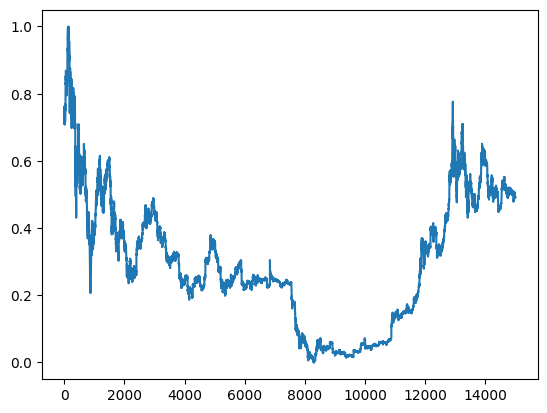

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(300,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
df.corr()

open      high       low     close    volume
open    1.000000  0.999960  0.999938  0.999926  0.131785
high    0.999960  1.000000  0.999907  0.999960  0.135111
low     0.999938  0.999907  1.000000  0.999950  0.126644
close   0.999926  0.999960  0.999950  1.000000  0.131278
volume  0.131785  0.135111  0.126644  0.131278  1.000000

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=5,batch_size=64,verbose=1)

Epoch 1/5
148/148 [==============================] - 208s 787ms/step - loss: 0.0023 - val_loss: 2.6603e-04
Epoch 2/5
148/148 [==============================] - 116s 784ms/step - loss: 2.3590e-04 - val_loss: 2.1107e-04
Epoch 3/5
148/148 [==============================] - 117s 787ms/step - loss: 2.0836e-04 - val_loss: 1.7642e-04
Epoch 4/5
148/148 [==============================] - 114s 770ms/step - loss: 1.8259e-04 - val_loss: 1.9755e-04
Epoch 5/5
148/148 [==============================] - 116s 785ms/step - loss: 1.8387e-04 - val_loss: 3.5051e-04


In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

155/155 [==============================] - 21s 139ms/step


In [ ]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
# math.sqrt(mean_squared_error(y_train,train_predict))
mean_absolute_error(y_train,train_predict)

6730.457551562271

In [ ]:
math.sqrt(mean_squared_error(ytest,test_predict))


8273.626398408927

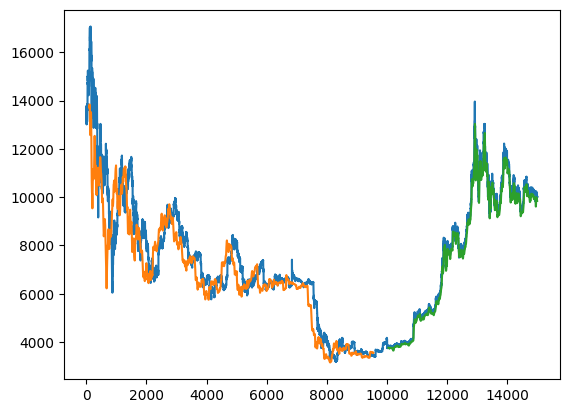

In [ ]:
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1+400:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00


In [ ]:
column_names = ['open','high','low','close']
df_sd = pd.DataFrame(df_s,columns=column_names)

In [ ]:
df_sd.head()

open      high       low     close
0  0.161054  0.160007  0.156884  0.158214
1  0.158203  0.158187  0.153138  0.153235
2  0.153223  0.155491  0.153821  0.155177
3  0.155167  0.158421  0.155199  0.156397
4  0.156767  0.158604  0.155692  0.159314

In [ ]:
df1=df['close'][:15000]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 300
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(300,1)))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 300, 100)          20800     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 100)               60400     
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 81301 (317.58 KB)
Trainable params: 81301 (317.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=5,batch_size=64,verbose=1)

Epoch 1/5
148/148 [==============================] - 157s 928ms/step - loss: 0.0025 - val_loss: 1.4511e-04
Epoch 2/5
148/148 [==============================] - 132s 895ms/step - loss: 1.2674e-04 - val_loss: 2.3949e-04
Epoch 3/5
148/148 [==============================] - 131s 882ms/step - loss: 1.0696e-04 - val_loss: 1.0135e-04
Epoch 4/5
148/148 [==============================] - 128s 868ms/step - loss: 9.8558e-05 - val_loss: 8.6615e-05
Epoch 5/5
148/148 [==============================] - 131s 883ms/step - loss: 8.5053e-05 - val_loss: 7.3720e-05


In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

155/155 [==============================] - 24s 154ms/step


In [ ]:
train_predict1=scaler.inverse_transform(train_predict)
test_predict1=scaler.inverse_transform(test_predict)

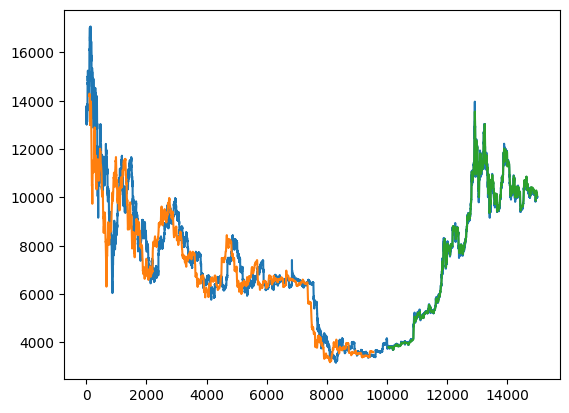

In [ ]:
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict1
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1+400:len(df1)-1, :] = test_predict1
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
df.head()

open      high       low     close
datetime                                                   
2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01
2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06
2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18
2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03
2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01

Epoch 1/5
188/188 [==============================] - 4s 11ms/step - loss: 0.0065 - val_loss: 1.2598e-04
Epoch 2/5
188/188 [==============================] - 2s 11ms/step - loss: 1.0951e-04 - val_loss: 1.1583e-04
Epoch 3/5
188/188 [==============================] - 3s 16ms/step - loss: 1.0423e-04 - val_loss: 1.1259e-04
Epoch 4/5
188/188 [==============================] - 2s 11ms/step - loss: 1.0062e-04 - val_loss: 1.1307e-04
Epoch 5/5
94/94 [==============================] - 0s 3ms/step - loss: 1.1329e-04
Model Test Loss: 0.00011328563414281234
94/94 [==============================] - 1s 4ms/step


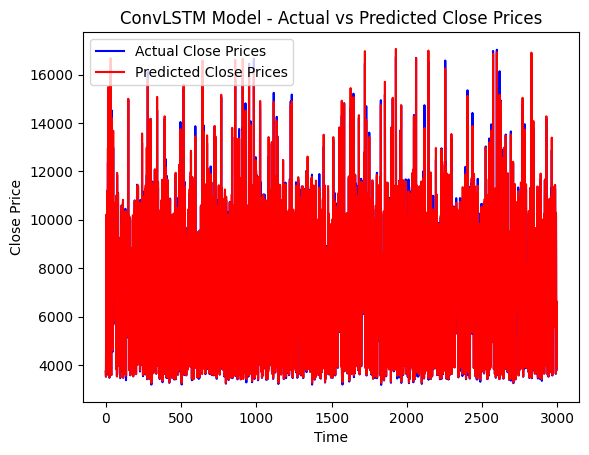

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense

# Load your dataset
# Assuming your dataset is a pandas DataFrame with columns: 'open', 'close', 'high', 'low'
# Adjust the file path accordingly
# data = pd.read_csv('your_dataset.csv')

# Extract the 'close' feature as your target variable
close_prices = df['close'][:15000].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)

# Function to create sequences from the time series data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

# Set sequence length (adjust as needed)
sequence_length = 10

# Create sequences and labels
X, y = create_sequences(close_prices_scaled, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for ConvLSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the ConvLSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Model Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to get actual close prices
predicted_prices = scaler.inverse_transform(predictions)
y_test_ = scaler.inverse_transform(y_test)

# Plot the actual vs predicted close prices
import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# plt.plot(y_test_, label='Actual Close Prices', color='blue')
# plt.plot(predicted_prices, label='Predicted Close Prices', color='red')
# plt.title('ConvLSTM Model - Actual vs Predicted Close Prices')
# plt.xlabel('Time')
# plt.ylabel('Close Price')
# plt.legend()
# plt.show()

In [ ]:
predicted_prices = scaler.inverse_transform(predictions)

In [ ]:
predicted_prices

array([[3682.1729],
       [3463.9424],
       [6427.1694],
       ...,
       [3998.8506],
       [6559.9478],
       [3857.6265]], dtype=float32)

In [ ]:
y_test

array([[0.03908909],
       [0.02490549],
       [0.23537568],
       ...,
       [0.06294117],
       [0.24356982],
       [0.05047152]])

In [ ]:
!pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
ERROR: Could not build wheels for fbprophet, which is required to install pyproject.toml-based projects


In [ ]:
!pip install pystan

  Using cached pystan-3.8.0-py3-none-any.whl (13 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached httpstan-4.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.8 MB)
  Using cached pysimdjson-5.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached crashtest-0.3.1-py3-none-any.whl (7.0 kB)
  Using cached pastel-0.2.1-py2.py3-none-any.whl (6.0 kB)
  Using cached pylev-1.4.0-py2.py3-none-any.whl (6.1 kB)
  Using cached marshmallow-3.20.2-py3-none-any.whl (49 kB)
  Using cached webargs-8.4.0-py3-none-any.whl (31 kB)


In [ ]:
!pip install lxml

In [ ]:
from prophet import Prophet

In [ ]:
data = data[['ds','y']]

In [ ]:
data = data[15000:26000]

In [ ]:
data.head()

datetime      open      high       low     close      volume
0  2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01  443.356199
1  2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06  383.697006
2  2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18  429.064572
3  2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03  420.087030
4  2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01  340.807329

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphu55gmf4/5sbqp2al.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphu55gmf4/9bxge86x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86973', 'data', 'file=/tmp/tmphu55gmf4/5sbqp2al.json', 'init=/tmp/tmphu55gmf4/9bxge86x.json', 'output', 'file=/tmp/tmphu55gmf4/prophet_modelb2hmuxac/prophet_model-20240120154206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


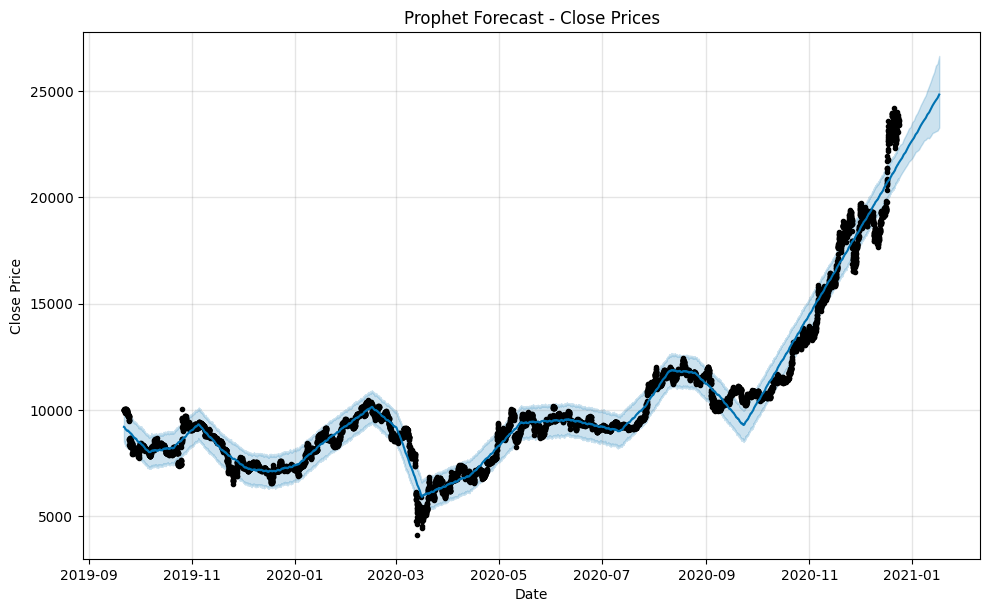

In [ ]:
# Create a Prophet model
model = Prophet()

data = pd.read_csv('btc_1h.csv')

# Rename columns to 'ds' and 'y' as required by Prophet
data = data.rename(columns={'close': 'y', 'datetime': 'ds'})

# Fit the model
model.fit(data[15000:26000])

# Create a DataFrame with future dates for prediction
future = model.make_future_dataframe(periods=24)  # Adjust the number of periods as needed

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Prophet Forecast - Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def objective(trial, data, target):
    # Split the data into training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.2, random_state=42)

    # Define hyperparameters to optimize
    params = {
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-9, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-9, 10.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # Train the XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    model = xgb.train(params, dtrain, evals=[(dvalid, 'valid')], verbose_eval=False)

    # Calculate Mean Squared Error on the validation set
    predictions = model.predict(dvalid)
    mse = mean_squared_error(y_valid, predictions)

    return mse

# Assuming df is your DataFrame with 'open', 'high', 'close', 'low' as features
data = df_sd[['open', 'high', 'low']]
target = df_sd['close']  # Replace 'your_target_column' with the actual target column

# Perform Bayesian optimization
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, data, target), n_trials=50)

# Print the best parameters and their corresponding score
print('Best Parameters:', study.best_params)
print('Best MSE:', study.best_value)

[I 2024-01-20 11:19:10,644] A new study created in memory with name: no-name-dbebfd71-901b-487e-9cf7-70a10e432eda
<ipython-input-75-cc7700efd5fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
<ipython-input-75-cc7700efd5fa>:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
<ipython-input-75-cc7700efd5fa>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 

Best Parameters: {'booster': 'gbtree', 'learning_rate': 0.09919158306150588, 'max_depth': 4, 'subsample': 0.6034486315070043, 'colsample_bytree': 0.9718718971504448, 'reg_alpha': 0.0008656393144458643, 'reg_lambda': 0.00022696872111498486, 'min_child_weight': 9}
Best MSE: 0.00935676531764004


In [ ]:
best_params = study.best_params
final_model = xgb.train(best_params, xgb.DMatrix(data, label=target))

In [ ]:
# Assuming df_test is your test set
data_test = df[['open', 'high', 'low']]
target_test = df['close']

dtest = xgb.DMatrix(data_test, label=target_test)
predictions_test = final_model.predict(dtest)
mse_test = mean_absolute_error(target_test, predictions_test)

print('MSE on Test Set:', mse_test)

MSE on Test Set: 18808.217447744257


In [ ]:
predictions_test

numpy.ndarray

In [ ]:
p_t = scaler.inverse_transform(predictions_test.reshape(-1,4))

In [ ]:
target_test

datetime
2018-01-01 05:30:00    13529.01
2018-01-01 06:30:00    13203.06
2018-01-01 07:30:00    13330.18
2018-01-01 08:30:00    13410.03
2018-01-01 09:30:00    13601.01
                         ...   
2022-01-31 01:30:00    37684.45
2022-01-31 02:30:00    37729.00
2022-01-31 03:30:00    37785.78
2022-01-31 04:30:00    37881.76
2022-01-31 05:30:00    36829.30
Name: close, Length: 35664, dtype: float64

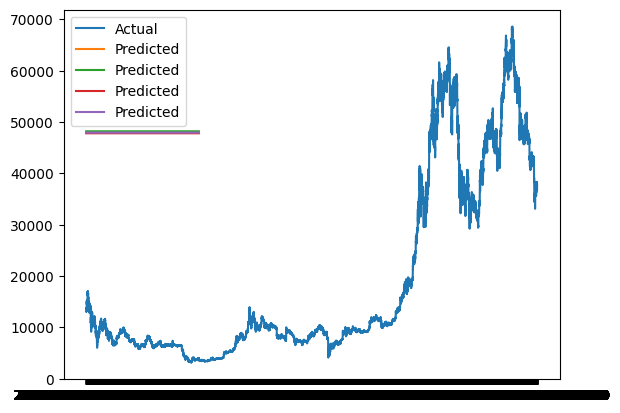

In [ ]:
import matplotlib.pyplot as plt

plt.plot(target_test, label='Actual')
plt.plot(p_t, label='Predicted')
plt.legend()
plt.show()

In [ ]:
df1 = df1.drop(columns=['volume'])

In [ ]:
df1[['open','high','low','close']].values

array([[13715.65, 13715.65, 13400.01, 13529.01],
       [13528.99, 13595.89, 13155.38, 13203.06],
       [13203.  , 13418.43, 13200.  , 13330.18],
       ...,
       [ 7067.52,  7067.62,  7020.  ,  7057.35],
       [ 7057.63,  7068.  ,  7024.14,  7043.38],
       [ 7043.17,  7074.71,  7026.09,  7060.33]])

In [ ]:
X = df1[['open','high','low','close']].values

In [ ]:
y=

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32)